In [4]:
import requests
import torch
from PIL import Image
from io import BytesIO

from diffusers import CycleDiffusionPipeline, DDIMScheduler

/home/haselab/anaconda3/envs/diffae/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-17 20:20:12.711619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 20:20:12.728905: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 20:20:12.734232: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-17 20:20:12.747203: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlo

In [5]:
def load_image(path, size=None):
    img = Image.open(path).convert('RGB')
    if size is not None:
        img = img.resize(size)
    return img

In [6]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
model_id_or_path = "stabilityai/stable-diffusion-2-base"
scheduler = DDIMScheduler.from_pretrained(model_id_or_path, subfolder="scheduler")
pipe = CycleDiffusionPipeline.from_pretrained(model_id_or_path, scheduler=scheduler).to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 11.09it/s]


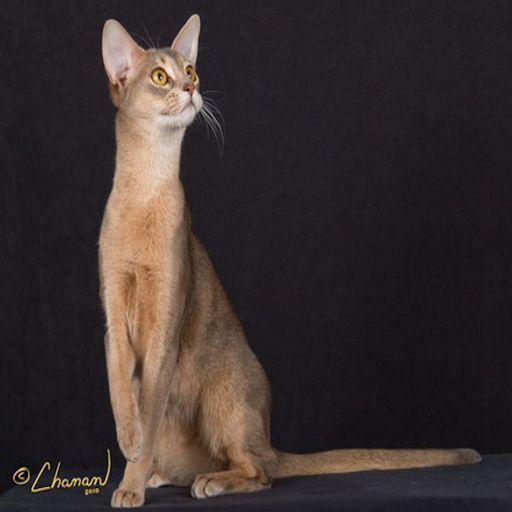

In [9]:
input_image = load_image("/home/haselab/projects/sakai/Adversarial-Perception-aware-Perturbation/data/images/Abyssinian_2.jpg", size=(512, 512))
input_image

In [10]:
source_prompt = "a photo of cat"
prompt = "a photo of cat with green background"

guidance_scale = 1.1

batch_size = 1 if isinstance(prompt, str) else len(prompt)
do_classifier_free_guidance = guidance_scale > 1.0

In [11]:
prompt_embed, negative_prompt_embed = pipe.encode_prompt(prompt, device, 1, do_classifier_free_guidance)
prompt_embed.shape

torch.Size([1, 77, 1024])

In [103]:
from transformers import AutoProcessor, CLIPVisionModel

model_name = "openai/clip-vit-large-patch14"
model = CLIPVisionModel.from_pretrained(model_name).to(device)
processor = AutoProcessor.from_pretrained(model_name)

In [107]:
def get_image_embeds(image, model, processor, device):
    with torch.no_grad():
        inputs = processor(images=image, return_tensors="pt", padding=True).to(device)
        outputs = model(**inputs)
    return outputs.last_hidden_state

image_embed = get_image_embeds(input_image, model, processor, device)
image_embed.shape

torch.Size([1, 257, 1024])

In [14]:
with torch.no_grad():
    inputs = processor(text=[source_prompt], images=input_image, return_tensors="pt", padding=True, truncation=True).to(device)
    outputs = model(**inputs, return_loss=True)

text_embeds = outputs.text_embeds
image_embeds = outputs.image_embeds
text_model_output = outputs.text_model_output
vision_model_output = outputs.vision_model_output
loss = outputs.loss

print(f"Text Embeds: {text_embeds.shape}")
print(f"Image Embeds: {image_embeds.shape}")
print(f"Text Model Output: {text_model_output.last_hidden_state.shape}")
print(f"Image Model Output: {vision_model_output.last_hidden_state.shape}")
print(f"Loss: {loss}")

Text Embeds: torch.Size([1, 768])
Image Embeds: torch.Size([1, 768])
Text Model Output: torch.Size([1, 6, 768])
Image Model Output: torch.Size([1, 257, 1024])
Loss: 0.0


In [15]:
pooled_visual_embeds = vision_model_output.pooler_output
print(pooled_visual_embeds.shape)

torch.Size([1, 1024])


In [156]:
def get_latent(pipe, image, prompt, source_prompt, num_inference_steps, strength, device, num_images_per_prompt, do_classifier_guidance):
    
    batch_size = 1 if isinstance(prompt, str) else len(prompt)
    # Encode the text prompt
    # Currently only support positive prompt
    prompt_embeds = pipe.encode_prompt(
        prompt, 
        device,
        num_images_per_prompt,
        do_classifier_guidance,
    )[0]
    source_prompt_embeds = pipe.encode_prompt(
        source_prompt, device, num_images_per_prompt, do_classifier_guidance
    )[0]
    print(f"Prompt Embeds: {prompt_embeds.shape}")
    print(f"Source Prompt Embeds: {source_prompt_embeds.shape}")
    
    # Process Image
    image = pipe.image_processor.preprocess(image)
    
    # timesteps
    pipe.scheduler.set_timesteps(num_inference_steps, device=device)
    timesteps, num_inference_steps = pipe.get_timesteps(num_inference_steps, strength, device)
    latent_timesteps = timesteps[:1].repeat(batch_size * num_images_per_prompt)
    
    # Prepare latents
    latents, clean_latents = pipe.prepare_latents(
        image, latent_timesteps, batch_size, num_images_per_prompt, prompt_embeds.dtype, device
    )
    return {
        "latents": latents,
        "clean_latents": clean_latents,
        "timesteps": timesteps,
        "prompt_embeds": prompt_embeds,
        "source_prompt_embeds": source_prompt_embeds,
    }

In [157]:
source_prompt = "a photo of cat"
prompt = "a photo of cat with green background"

In [168]:
num_inference_steps = 100
strength = 0.5
num_images_per_prompt = 1
do_classifier_gudance = False

outputs = get_latent(pipe, input_image, prompt, source_prompt, num_inference_steps, strength, device, num_images_per_prompt, do_classifier_gudance)
latents = outputs["latents"]
clean_latents = outputs["clean_latents"]
timesteps = outputs["timesteps"]
# prompt_embeds = outputs["prompt_embeds"]
# source_prompt_embeds = outputs["source_prompt_embeds"]
prompt_embeds = get_image_embeds(input_image, model, processor, device)
source_prompt_embeds = prompt_embeds

print(latents.shape)
print(clean_latents.shape)
print(timesteps.shape)
print(prompt_embeds.shape)
print(source_prompt_embeds.shape)

Prompt Embeds: torch.Size([1, 77, 1024])
Source Prompt Embeds: torch.Size([1, 77, 1024])
torch.Size([1, 4, 64, 64])
torch.Size([1, 4, 64, 64])
torch.Size([50])
torch.Size([1, 257, 1024])
torch.Size([1, 257, 1024])


In [169]:
from typing import Union, Tuple, List, Optional
import torch
from logging import getLogger


def randn_tensor(
    shape: Union[Tuple, List],
    generator: Optional[Union[List["torch.Generator"], "torch.Generator"]] = None,
    device: Optional["torch.device"] = None,
    dtype: Optional["torch.dtype"] = None,
    layout: Optional["torch.layout"] = None,
):
    """A helper function to create random tensors on the desired `device` with the desired `dtype`. When
    passing a list of generators, you can seed each batch size individually. If CPU generators are passed, the tensor
    is always created on the CPU.
    """
    # device on which tensor is created defaults to device
    rand_device = device
    batch_size = shape[0]

    layout = layout or torch.strided
    device = device or torch.device("cpu")

    if generator is not None:
        gen_device_type = generator.device.type if not isinstance(generator, list) else generator[0].device.type
        if gen_device_type != device.type and gen_device_type == "cpu":
            rand_device = "cpu"
            if device != "mps":
                logger.info(
                    f"The passed generator was created on 'cpu' even though a tensor on {device} was expected."
                    f" Tensors will be created on 'cpu' and then moved to {device}. Note that one can probably"
                    f" slighly speed up this function by passing a generator that was created on the {device} device."
                )
        elif gen_device_type != device.type and gen_device_type == "cuda":
            raise ValueError(f"Cannot generate a {device} tensor from a generator of type {gen_device_type}.")

    # make sure generator list of length 1 is treated like a non-list
    if isinstance(generator, list) and len(generator) == 1:
        generator = generator[0]

    if isinstance(generator, list):
        shape = (1,) + shape[1:]
        latents = [
            torch.randn(shape, generator=generator[i], device=rand_device, dtype=dtype, layout=layout)
            for i in range(batch_size)
        ]
        latents = torch.cat(latents, dim=0).to(device)
    else:
        latents = torch.randn(shape, generator=generator, device=rand_device, dtype=dtype, layout=layout).to(device)

    return latents

def posterior_sample(scheduler, latents, timestep, clean_latents, generator, eta):
    # 1. get previous step value (=t-1)
    prev_timestep = timestep - scheduler.config.num_train_timesteps // scheduler.num_inference_steps

    if prev_timestep <= 0:
        return clean_latents

    # 2. compute alphas, betas
    alpha_prod_t = scheduler.alphas_cumprod[timestep]
    alpha_prod_t_prev = (
        scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.final_alpha_cumprod
    )

    variance = scheduler._get_variance(timestep, prev_timestep)
    std_dev_t = eta * variance ** (0.5)

    # direction pointing to x_t
    e_t = (latents - alpha_prod_t ** (0.5) * clean_latents) / (1 - alpha_prod_t) ** (0.5)
    dir_xt = (1.0 - alpha_prod_t_prev - std_dev_t**2) ** (0.5) * e_t
    noise = std_dev_t * randn_tensor(
        clean_latents.shape, dtype=clean_latents.dtype, device=clean_latents.device, generator=generator
    )
    prev_latents = alpha_prod_t_prev ** (0.5) * clean_latents + dir_xt + noise

    return prev_latents

def compute_noise(scheduler, prev_latents, latents, timestep, noise_pred, eta):
    # 1. get previous step value (=t-1)
    prev_timestep = timestep - scheduler.config.num_train_timesteps // scheduler.num_inference_steps

    # 2. compute alphas, betas
    alpha_prod_t = scheduler.alphas_cumprod[timestep]
    alpha_prod_t_prev = (
        scheduler.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else scheduler.final_alpha_cumprod
    )

    beta_prod_t = 1 - alpha_prod_t

    # 3. compute predicted original sample from predicted noise also called
    # "predicted x_0" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
    pred_original_sample = (latents - beta_prod_t ** (0.5) * noise_pred) / alpha_prod_t ** (0.5)

    # 4. Clip "predicted x_0"
    if scheduler.config.clip_sample:
        pred_original_sample = torch.clamp(pred_original_sample, -1, 1)

    # 5. compute variance: "sigma_t(η)" -> see formula (16)
    # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
    variance = scheduler._get_variance(timestep, prev_timestep)
    std_dev_t = eta * variance ** (0.5)

    # 6. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
    pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2) ** (0.5) * noise_pred

    noise = (prev_latents - (alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction)) / (
        variance ** (0.5) * eta
    )
    return noise

def denoising(latents, clean_latents, pipe, device, strength, timesteps, prompt_embeds, source_prompt_embeds, guidance_scale, num_inference_steps, do_classifier_free_guidance, eta=1.0):
    latents = latents.to(device)
    clean_latents = clean_latents.to(device)
    
    source_latents = latents.clone()
    num_warmup_steps = len(timesteps) - num_inference_steps * pipe.scheduler.order
    with pipe.progress_bar(total=num_inference_steps) as progress_bar:
        for i, t in enumerate(timesteps):
            
            latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
            source_latent_model_input  = torch.cat([source_latents] * 2) if do_classifier_free_guidance else source_latents
            latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
            source_latent_model_input = pipe.scheduler.scale_model_input(source_latent_model_input, t)
            
            # Denoise
            if do_classifier_free_guidance:
                concat_latent_model_input = torch.stack([
                    source_prompt_embeds[0], 
                    prompt_embeds[0],
                    source_latent_model_input[1],
                    latent_model_input[1],
                ], dim=0)
                concat_prompt_embeds = torch.stack([
                    source_prompt_embeds[0],
                    prompt_embeds[0],
                    source_prompt_embeds[1],
                    prompt_embeds[1],
                ], dim=0)
            else:
                concat_latent_model_input = torch.cat([source_latent_model_input, latent_model_input], dim=0)
                concat_prompt_embeds = torch.cat([source_prompt_embeds, prompt_embeds], dim=0)
            
            with torch.no_grad():
                concat_noise_pred = pipe.unet(
                    concat_latent_model_input,
                    t,
                    encoder_hidden_states=concat_prompt_embeds
                ).sample
            
            if do_classifier_free_guidance:
                (
                    source_noise_pred_uncond,
                    noise_pred_uncond,
                    source_noise_pred_text,
                    noise_pred_text,
                ) = concat_noise_pred.chunk(4, dim=0)
                
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
                source_noise_pred = source_noise_pred_uncond + guidance_scale * (source_noise_pred_text - source_noise_pred_uncond)
            else:
                source_noise_pred, noise_pred = concat_noise_pred.chunk(2, dim=0)
            
            prev_source_latents = posterior_sample(
                pipe.scheduler, source_latents, t, clean_latents, generator=None, eta=eta
            )
            noise = compute_noise(
                pipe.scheduler, prev_source_latents, source_latents, t, source_noise_pred, eta=eta
            )
            source_latents = prev_source_latents
            
            # compute previous noisy sample
            latents = pipe.scheduler.step(
                noise_pred, t, latents, variance_noise=noise
            ).prev_sample
            
            if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % pipe.scheduler.order == 0):
                progress_bar.update()
    
    # post process
    image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]
    image = image.cpu().detach()
    image = pipe.image_processor.postprocess(image, output_type="pil")
    return image

In [170]:
noise_scale = 0.0
prompt_noise = torch.randn_like(prompt_embeds) * noise_scale
prompt_embeds = prompt_embeds + prompt_noise

In [171]:
new_image = denoising(latents, clean_latents, pipe, device, strength, timesteps, prompt_embeds, source_prompt_embeds, guidance_scale, num_inference_steps, do_classifier_gudance)

 50%|█████     | 50/100 [00:05<00:05,  9.55it/s]


(-0.5, 511.5, 511.5, -0.5)

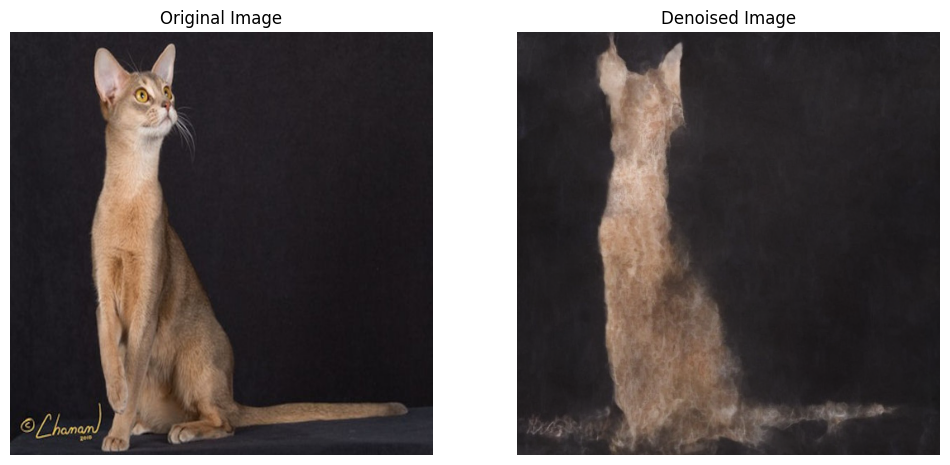

In [172]:
# Compare the original image and the denoised image
org_img = input_image
denoised_img = new_image[0]

# PIL to numpy
import numpy as np
import matplotlib.pyplot as plt
org_img = np.array(org_img)
denoised_img = np.array(denoised_img)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(org_img)
ax[0].set_title("Original Image")
ax[0].axis("off")
ax[1].imshow(denoised_img)
ax[1].set_title("Denoised Image")
ax[1].axis("off")

In [180]:
from diffusers import DiffusionPipeline
from diffusers.utils import load_image
import torch

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-unclip-small", torch_dtype=torch.float16)
pipe.to("cuda")


100%|██████████| 21/21 [00:01<00:00, 13.83it/s]


In [193]:
# get image
url = "https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/stable_unclip/tarsila_do_amaral.png"
image = input_image
# run image variation
gen_image = pipe(image).images[0]

100%|██████████| 21/21 [00:01<00:00, 13.74it/s]


(-0.5, 767.5, 767.5, -0.5)

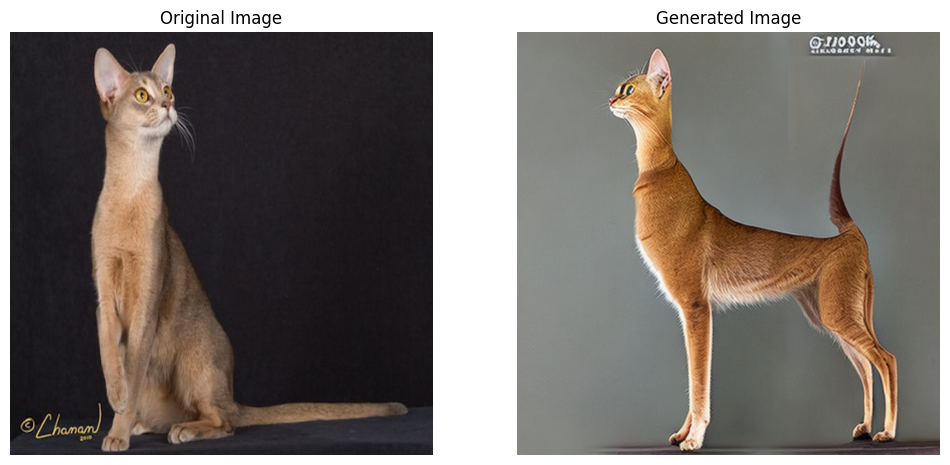

In [194]:
# PIL to numpy
import numpy as np
import matplotlib.pyplot as plt

image = np.array(image)
gen_image = np.array(gen_image)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")
ax[1].imshow(gen_image)
ax[1].set_title("Generated Image")
ax[1].axis("off")

In [1]:
#pip install git+https://github.com/huggingface/diffusers.git transformers accelerate
import requests
import torch
from PIL import Image
from io import BytesIO

from diffusers import StableUnCLIPImg2ImgPipeline

#Start the StableUnCLIP Image variations pipeline
pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-unclip", torch_dtype=torch.float16, variation="fp16"
)
pipe = pipe.to("cuda")

#Get image from URL
url = "https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/stable_unclip/tarsila_do_amaral.png"
response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")

#Pipe to make the variation
images = pipe(init_image).images
images[0].save("tarsila_variation.png")

/home/haselab/anaconda3/envs/diffae/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-18 15:21:48.718472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 15:21:48.736473: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 15:21:48.741993: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-18 15:21:48.755421: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlo

In [ ]:
import torch
from diffusers import UnCLIPScheduler, DDPMScheduler, StableUnCLIPPipeline
from diffusers.models import PriorTransformer
from transformers import CLIPTokenizer, CLIPTextModelWithProjection